In [1]:
import itertools

In [1]:
import matplotlib

In [2]:
matplotlib.use('Agg')

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt

In [2]:
import os

In [3]:
import re

---

# Preparing genetic interactions from BIOGRID

**2015 July 4-6, 8; August 3**

Previously, in Lee et al. "Predicting genetic modifier loci using functional gene networks" (2010), yeast genetic interactions were predicted using the functional network approach. The sources for the seed data were:

- Tong AH et al. 2004. Global mapping of the yeast genetic interaction network. Science 303:808. PMID 14764870.
- Davierwala AP et al. 2005. The synthetic genetic interaction spectrum of essential genes. Nat Genet 37:1147. PMID 16155567.

Lee et al. used YeastNet v2, and while it contains genetic interactions, it doesn't contain the most recent datasets, such as the Costanzo et al. 2010 Science paper. The objective now is to evaluate the functional network approach on these newer interaction data. Note that is now a newer version of YeastNet (v3). 

The sources listed above will need to be excluded from this analysis. The BIOGRID database has entries for "Author" and "Pubmed ID". Checking whether the Tong AH (2004) and Davierwala AP (2005) papers are listed in version 3.3.124:

In [1]:
%%bash
cd /work/jyoung/DataDownload/BIOGRID/BIOGRID-ORGANISM-3.3.124.tab2/
grep 14764870 BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.3.124.tab2.txt | wc -l

4369


In [2]:
%%bash
cd /work/jyoung/DataDownload/BIOGRID/BIOGRID-ORGANISM-3.3.124.tab2/
grep 14764870 BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.3.124.tab2.txt | head -1

108850	855450	851373	35569	31885	YNL271C	YDL225W	BNI1	SHS1	PPF3|SHE5|formin BNI1|L000000190	SEP7|septin SHS1	Synthetic Lethality	genetic	Tong AH (2004)	14764870	559292	559292	High Throughput	-	-	inviable	-	-	BIOGRID


In [3]:
%%bash
cd /work/jyoung/DataDownload/BIOGRID/BIOGRID-ORGANISM-3.3.124.tab2/
grep 16155567 BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.3.124.tab2.txt | wc -l

567


In [4]:
%%bash
cd /work/jyoung/DataDownload/BIOGRID/BIOGRID-ORGANISM-3.3.124.tab2/
grep 16155567 BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.3.124.tab2.txt | head -1

484166	851532	852538	32027	32931	YDL029W	YBR236C	ARP2	ABD1	ACT2|actin-related protein 2|L000000026	L000000011	Synthetic Growth Defect	genetic	Davierwala AP (2005)	16155567	559292	559292	High Throughput	-	-	vegetative growth	SGA screen	-	BIOGRID


Also checking the Costanzo 2010 Science paper:

In [5]:
%%bash
cd /work/jyoung/DataDownload/BIOGRID/BIOGRID-ORGANISM-3.3.124.tab2/
grep 20093466 BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.3.124.tab2.txt | wc -l

68087


In [6]:
%%bash
cd /work/jyoung/DataDownload/BIOGRID/BIOGRID-ORGANISM-3.3.124.tab2/
grep 20093466 BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.3.124.tab2.txt | head -1

354378	851236	850395	31767	31012	YAL063C	YCR028C-A	FLO9	RIM1	flocculin FLO9|L000003331	L000001640	Negative Genetic	genetic	Costanzo M (2010)	20093466	559292	559292	High Throughput	-0.1969	-	colony size	A Synthetic Genetic Array (SGA) analysis was carried out to quantitatively score genetic interactions based on fitness defects that were estimated from the colony size of double versus single mutants. Genetic interactions were considered significant if they had an SGA score of epsilon > 0.08 for positive interactions and epsilon < -0.08 for negative interactions, and a p-value < 0.05.	-	BIOGRID


<s>So now process the BIOGRID *S. cerevisiae* file to remove Tong AH (2004) and Davierwala AP (2005), and keep only those lines for genetic interactions. But first download the latest version of BIOGRID (v3.4.126).</s>

The Tong and Davierwala datasets were used as seed sets in the 2010 Genome Research paper. While these definitely need to be removed, note that YeastNet v2 [1] itself contains other genetic interactions. In particular, "genetic interactions (GI) were collected from...BioGRID (downloaded on June 2006)..." [1]. 

Therefore, remove every genetic interaction before 2007 from BIOGRID. This would also remove anything from Tong and Davierwala. 

[1] Lee I, Li Z, Marcotte EM (2007) An Improved, Bias-Reduced Probabilistic Functional Gene Network of Baker's Yeast, Saccharomyces cerevisiae. PLoS ONE 2(10): e988.

In [3]:
os.chdir('/work/jyoung/DataDownload/BIOGRID/BIOGRID-ORGANISM-3.4.127.tab2')

In [4]:
readFile = open('BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.4.127.tab2.txt')
writeFile = open('/work/jyoung/genetic_interact/data/BIOGRID-3.4.127-for-yeastnetv2.txt', 'w')
header = readFile.readline().rstrip().split('\t')
PMIDcolNum = header.index('Pubmed ID')
expSysTypeCol = header.index('Experimental System Type')
authorCol = header.index('Author')
for line in readFile:
    tokens = line.rstrip().split('\t')
    ##if tokens[PMIDcolNum] != '14764870' and tokens[PMIDcolNum] != '16155567':
    ##    if tokens[expSysTypeCol] == 'genetic':
    ##        writeFile.write(line)
    if tokens[expSysTypeCol] == 'genetic':
        author = tokens[authorCol]
        year = int(re.search(r'\((\d+)\)', author).group(1))
        if year > 2006:
            writeFile.write(line)
readFile.close()
writeFile.close()

Download YeastNet v2:

    wget http://www.functionalnet.org/yeastnet/data/yeastnet2.benchmarkset.gene.txt
    wget http://www.functionalnet.org/yeastnet/data/yeastnet2.benchmarkset.orf.txt
    wget http://www.functionalnet.org/yeastnet/data/yeastnet2.gene.txt
    wget http://www.functionalnet.org/yeastnet/data/yeastnet2.orf.txt
    wget http://www.functionalnet.org/yeastnet/data/yeastnet2-evidence.gene.txt
    wget http://www.functionalnet.org/yeastnet/data/yeastnet2-evidence.orf.txt

The network genes are in either gene name (i.e. RPC19) or ORF (i.e. YNL113W). The function *read_biogrid( )* in the script *func_net_pred.py* will need to be modified to accept arguments for compiling genetic interactions in either systematic name or official symbol. 

**2015 August 2**

Go back and download the newest version (3.4.127) of BIOGRID:

    wget http://thebiogrid.org/downloads/archives/Release%20Archive/BIOGRID-3.4.127/BIOGRID-ORGANISM-3.4.127.tab2.zip
    mkdir BIOGRID-ORGANISM-3.4.127.tab2
    unzip BIOGRID-ORGANISM-3.4.127.tab2.zip -d BIOGRID-ORGANISM-3.4.127.tab2/

Re-do the removal of old genetic interaction datasets as above. 

Modify the *read_biogrid( )* function in *func_net_pred.py* to read in the columns for systematic name interactors. Note that the columns are now a hard-coded parameter. Systematic name interactors are columns 5 & 6, while official symbol interactors are 7 & 8. 

---

# Breakdown of experimental evidence codes

**2015 August 3**

In [5]:
os.chdir('/work/jyoung/genetic_interact/data')

In [6]:
def experimental_evidence_breakdown(filename, colNum):
    """
    INPUT:
    1.) <string> name of BIOGRID file to read
    2.) <integer> number of interactor column to read
    """
    typeCounts = dict()
    genes = set()
    for line in open(filename):
        tokens = line.split('\t')
        genes.update(tokens[colNum:colNum+2])
        typeCounts[tokens[11]] = typeCounts.get(tokens[11], 0) + 1
    print('Number of genes:', len(genes))
    print('Experimental evidence code breakdown:')
    print(typeCounts)

In [7]:
biogridFilename = 'BIOGRID-3.4.127-for-yeastnetv2.txt'

In [8]:
sysNameCol = 5  # systematic name

In [9]:
experimental_evidence_breakdown(biogridFilename, sysNameCol)

Number of genes: 5558
Experimental evidence code breakdown:
{'Dosage Rescue': 1897, 'Phenotypic Suppression': 5335, 'Negative Genetic': 110089, 'Phenotypic Enhancement': 5343, 'Synthetic Lethality': 6160, 'Synthetic Growth Defect': 13287, 'Positive Genetic': 23237, 'Synthetic Rescue': 4114, 'Dosage Lethality': 1120, 'Dosage Growth Defect': 1859, 'Synthetic Haploinsufficiency': 282}


In [10]:
symbolCol = 7  # official symbol

In [11]:
experimental_evidence_breakdown(biogridFilename, symbolCol)

Number of genes: 5593
Experimental evidence code breakdown:
{'Dosage Rescue': 1897, 'Phenotypic Suppression': 5335, 'Negative Genetic': 110089, 'Phenotypic Enhancement': 5343, 'Synthetic Lethality': 6160, 'Synthetic Growth Defect': 13287, 'Positive Genetic': 23237, 'Synthetic Rescue': 4114, 'Dosage Lethality': 1120, 'Dosage Growth Defect': 1859, 'Synthetic Haploinsufficiency': 282}


---

# Predictability for BIOGRID interactions types

**2015 August 4-7**

Major updates to *func_net_pred.py*. It no longer requires working only with Entrez IDs. The *get_entrez_indices( )* function has been replaced with the *assign_gene_indices( )* function. Sorting of gene IDs still occurs so that every time the script is run, the indices of the adjacency matrix always correspond to the same gene IDs. The *write_seeds_text( )* function no longer does a gene ID conversion. The *main( )* function contains a flag variable that indicates whether or not any conversion needs to be done. Note that the conversion should be based from the functional network; that is, the conversion dictionary should be built from converting the genes in the network. 

In an ideal scenario, the functional network and the BIOGRID file use the same gene IDs. If not, then convert to Entrez, as it seems to have less ambiguity than either official symbols or systematic name. For example, the R conversion has names such as "CG6646 gene product from transcript CG6646-RA", while BIOGRID simply uses "CG6646".

**2015 August 7**

Using BIOGRID v3.4.127 and YeastNet v2 with gene names (official symbol for BIOGRID). 

In [7]:
os.chdir('/work/jyoung/genetic_interact/src')

Number of genes in functional network: 5483
Number of genes in interactions: 1436
Number of seed sets: 1167


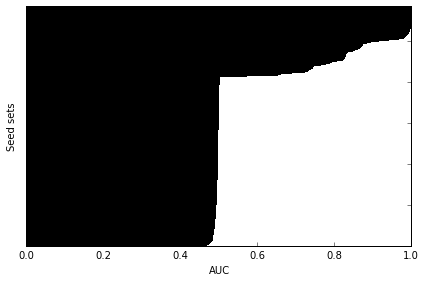

In [9]:
%run func_net_pred 'Dosage Rescue'

Number of genes in functional network: 5483
Number of genes in interactions: 1776
Number of seed sets: 1537


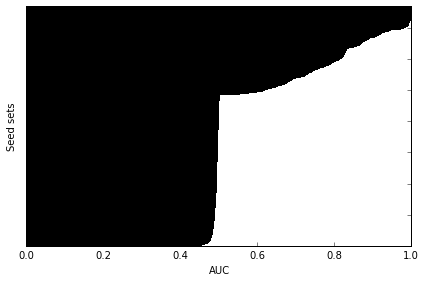

In [10]:
%run func_net_pred 'Phenotypic Suppression'

Number of genes in functional network: 5483
Number of genes in interactions: 4739
Number of seed sets: 3975


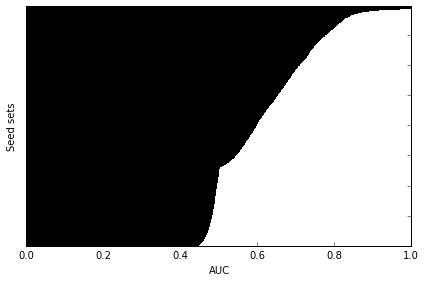

In [11]:
%run func_net_pred 'Negative Genetic'

Number of genes in functional network: 5483
Number of genes in interactions: 1988
Number of seed sets: 1727


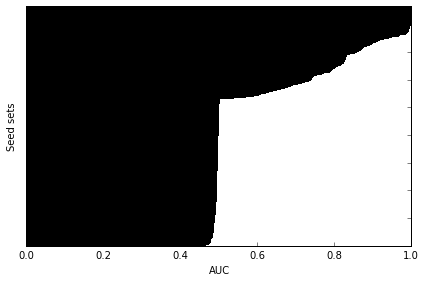

In [12]:
%run func_net_pred 'Phenotypic Enhancement'

Number of genes in functional network: 5483
Number of genes in interactions: 2721
Number of seed sets: 2430


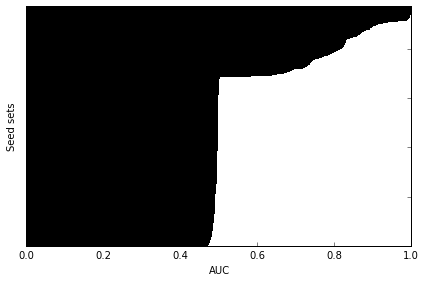

In [13]:
%run func_net_pred 'Synthetic Lethality'

Number of genes in functional network: 5483
Number of genes in interactions: 3391
Number of seed sets: 2913


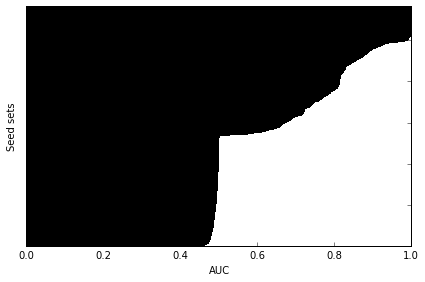

In [14]:
%run func_net_pred 'Synthetic Growth Defect'

Number of genes in functional network: 5483
Number of genes in interactions: 3803
Number of seed sets: 3171


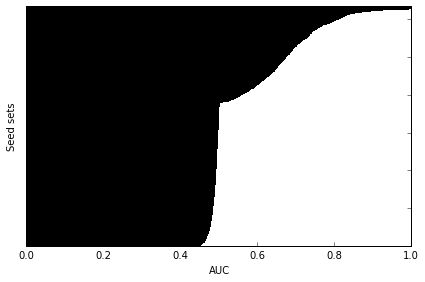

In [15]:
%run func_net_pred 'Positive Genetic'

Number of genes in functional network: 5483
Number of genes in interactions: 2153
Number of seed sets: 1798


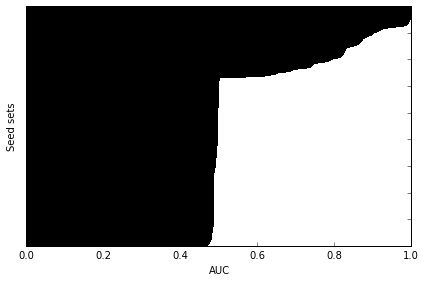

In [16]:
%run func_net_pred 'Synthetic Rescue'

Number of genes in functional network: 5483
Number of genes in interactions: 932
Number of seed sets: 610


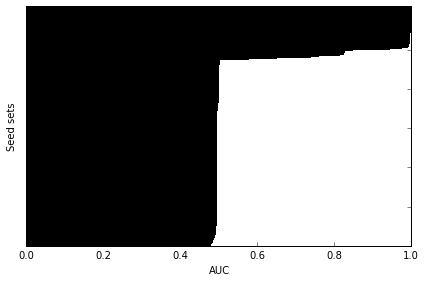

In [17]:
%run func_net_pred 'Dosage Lethality'

Number of genes in functional network: 5483
Number of genes in interactions: 1192
Number of seed sets: 1001


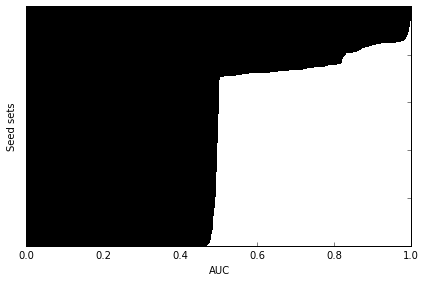

In [18]:
%run func_net_pred 'Dosage Growth Defect'

Number of genes in functional network: 5483
Number of genes in interactions: 274
Number of seed sets: 259


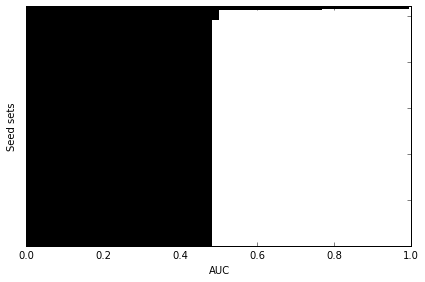

In [19]:
%run func_net_pred 'Synthetic Haploinsufficiency'

---

# Output Gene Names in Predictive Seed Sets

**2015 August 7**

Since the official symbols were used for both the functional network and BIOGRID, no ID conversion is needed. 

In [20]:
%run func_net_pred 'Dosage Rescue'

Number of genes in functional network: 5483
Number of genes in interactions: 1436
Number of seed sets: 1167


Repeated for the other interaction types.

---

# Validation

**2015 August 14-15, 19, 21, 26, 28**

One validation strategy is to use a time-split approach. Find predictive seed gene sets using genetic interactions from a certain time period, and then validate those predictions using genetic interaction data determined after that time period. An important consideration is that YeastNet v2 uses data from BIOGRID downloaded June 2006. (What about YeastNet v1??) If using YeastNet v2, an approach could involve predicting on interactions from 2007-2009, and then validating on 2010-present (which would include the 2010 Costanzo SGA study). 

<s>It would be informative to identify the breakdown of the years of sources from BIOGRID (e.g. how many sources are of a given year).</s>

Make 3 sets of genetic interactions: 1) pre-2007 2) 2007-2009 3) 2010-present. Check that they are mutually exclusive. 

In [4]:
def get_gene_pairs(interactionType, year1, year2):
    """
    Retrieve genetically interacting pairs from certain years
    INPUT:
        <int> years (inclusive) that source year should fall within
    OUTPUT:
        <set> genetically interacting pairs
    """
    genePairs = set()
    os.chdir('/work/jyoung/DataDownload/BIOGRID/BIOGRID-ORGANISM-3.4.127.tab2')
    readFile = open('BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.4.127.tab2.txt')
    header = readFile.readline().rstrip().split('\t')
    authorCol = header.index('Author')
    interactionTypeCol = header.index('Experimental System')
    for line in readFile:
        tokens = line.rstrip().split('\t')
        if tokens[interactionTypeCol] == interactionType:
            author = tokens[authorCol]
            year = int(re.search(r'\((\d+)\)', author).group(1))
            if year >= year1 and year <= year2:
                if tokens[7] != tokens[8]:  # e.g. CDC15
                    genePairs.add(frozenset({tokens[7], tokens[8]}))
    readFile.close()
    return genePairs

In [5]:
pre2007 = get_gene_pairs('Dosage Rescue', 1900, 2006)
from2007to2009 = get_gene_pairs('Dosage Rescue', 2007, 2009)
after2009 = get_gene_pairs('Dosage Rescue', 2010, 2015)

In [29]:
list(pre2007 & from2007to2009)[:3]

[frozenset({'CDC42', 'CLA4'}),
 frozenset({'GLO3', 'SEC22'}),
 frozenset({'MEX67', 'MTR2'})]

So the gene sets aren't mutually exclusive, even for a given interaction type. Thus the genetic interaction sets will have to updated to ensure they are pairwise disjoint. For now, only the interactions from 2007-2009 will need to be written out to a file.

In [5]:
def write_disjoint_gene_sets(timeSet, interactionType):
    """
    INPUT: <string> type of genetic interaction
    """
    pre2007 = get_gene_pairs(interactionType, 1900, 2006)
    incl0709 = get_gene_pairs(interactionType, 2007, 2009)
    post2009 = get_gene_pairs(interactionType, 2010, 2015)
    pre2007 = pre2007 - (incl0709 | post2009)
    incl0709 = incl0709 - post2009
    str2var = {'pre2007': pre2007, 'incl0709': incl0709, 'post2009': post2009}
    os.chdir('/work/jyoung/genetic_interact/data/yeast_time_split')
    timeSetFile = open(timeSet + '-' + ''.join(interactionType.split()) + '.txt', 'w')
    for pair in str2var[timeSet]:
        timeSetFile.write('\t'.join(pair) + '\n')
    timeSetFile.close()

In [6]:
timeSplits = ('pre2007', 'incl0709', 'post2009')

In [7]:
interactionTypes = ('Dosage Rescue', 'Phenotypic Suppression', 'Negative Genetic', 
                    'Phenotypic Enhancement', 'Synthetic Lethality', 'Synthetic Growth Defect', 
                    'Positive Genetic', 'Synthetic Rescue', 'Dosage Lethality', 
                    'Dosage Growth Defect', 'Synthetic Haploinsufficiency')

In [8]:
for x in itertools.product(timeSplits, interactionTypes):
    write_disjoint_gene_sets(x[0], x[1])

**2015 August 24-28**

Add to the *func_net_pred.py* script code to output predicted interactors and assess performance. 

Regarding the validation of the predictions, a predicted interactor will be called positive if it shows up in the post-2009 set and not in the pre-2007 set. It will be called negative if it shows up in neither the pre-2007 nor the post-2009 sets. 

NOTE: <br>
BIOGRID interaction ID 644337 has CDC15 (YAR019C) interacting with itself. This causes problems when using storing genetically interacting pairs in *frozenset* as done in *get_gene_pairs( )* above. 